In [ ]:
! pip install transformers

In [ ]:
df = pd.DataFrame(columns=['Posts', 'Label'])
for chunk in pd.read_csv('/content/drive/MyDrive/Thesis Papers/SMHD/final_cleaned_data.csv', chunksize=5000):
  df = df.append(chunk, ignore_index=True)

In [ ]:
ndf = df

In [ ]:
df=ndf

In [ ]:
df['Label'].value_counts()

control          15202
depression       14139
bipolar           6434
ptsd              2894
schizophrenia     1331
Name: Label, dtype: int64

In [ ]:
df_c=df[df["Label"] == "control"]
df_c = df_c.sample(frac=1).iloc[0:10000]

In [ ]:
df =df[df.Label != 'bipolar']
df =df[df.Label != 'ptsd']
df =df[df.Label != 'schizophrenia']
df =df[df.Label != 'control']

In [ ]:
df = df.sample(frac=1).iloc[0:10000]

In [ ]:
df = df.append(df_c,ignore_index=True)
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [ ]:
df.head()

,Posts,Label
0,please no links would like to sleep tonight i ...,control
1,i cannot complete any dungeons if am not playi...,depression
2,its usually been just paper when started when ...,depression
3,thanks man yeah every one at the shop is grea...,control
4,water bottle well am screwed i cried tears of...,depression


In [ ]:
df['Label'].value_counts()

control       10000
depression    10000
Name: Label, dtype: int64

In [ ]:
def cut(sen, length = 260):
  content = sen.split()
  if len(content) <= length:
    return " ".join(i for i in content)

  return " ".join(i for i in content[0:length])

In [ ]:
df['Posts'] = df['Posts'].apply(lambda x: cut(x))
df['Label'] = df['Label'].apply(lambda x: 1 if x=='depression' else 0)

In [ ]:
df.head()

,Posts,Label
0,please no links would like to sleep tonight i ...,0
1,i cannot complete any dungeons if am not playi...,1
2,its usually been just paper when started when ...,1
3,thanks man yeah every one at the shop is great...,0
4,water bottle well am screwed i cried tears of ...,1


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    return tokenizer

class GPReviewDataset(Dataset):
    
    def __init__(self, doc, targets, tokenizer, max_len):
        self.doc = doc
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.doc)
  
    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    truncation=True,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                    )

        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        doc=df.Posts.to_numpy(),
        targets=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
        )

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
if __name__=="__main__":
    
    

    class_names=['control', 'depression']
    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

    # sample_txt='Personal Health Record (Extract)\nCreated on October 24, 2019\nPatient\nSteven Fuerst\nBirthdate\nDecember 10, 1979\nRace\nInformation not\navailable'

    # tokens = tokenizer.tokenize(sample_txt)
    # token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # encoding = tokenizer.encode_plus(
    #                   sample_txt,
    #                   max_length=64,
    #                   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    #                   return_token_type_ids=False,
    #                   pad_to_max_length=True,
    #                   return_attention_mask=True,
    #                   return_tensors='pt',  # Return PyTorch tensors
    #                 )

    
    
    MAX_LEN = 256
    BATCH_SIZE = 6

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df.Label.values)
    df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test.Label.values)

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    data = next(iter(train_data_loader))

    bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    # last_hidden_state, pooled_output = bert_model(
    #                 input_ids=encoding['input_ids'], 
    #                 attention_mask=encoding['attention_mask'])

    model = SentimentClassifier(len(class_names))
    model = model.to(device)

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)


    EPOCHS = 12

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)


    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 60)

        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, int(len(df_train)))

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        int(len(df_val))
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
        
    test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          int(len(df_test))
        )
    print('\nTest Accuracy:\n')
    print(test_acc.item())

    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

    print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relation

Epoch 1/12
------------------------------------------------------------
Train loss 0.6685085586552589 accuracy 0.5962500000000001
Val   loss 0.6123786939832265 accuracy 0.7035

Epoch 2/12
------------------------------------------------------------
Train loss 0.6198237611251151 accuracy 0.6826875
Val   loss 0.6183052661711584 accuracy 0.686

Epoch 3/12
------------------------------------------------------------
Train loss 0.6499980132667859 accuracy 0.619
Val   loss 0.6005218671913632 accuracy 0.6975

Epoch 4/12
------------------------------------------------------------
Train loss 0.6018956394584651 accuracy 0.7028125000000001
Val   loss 0.6087241349462977 accuracy 0.6955

Epoch 5/12
------------------------------------------------------------
Train loss 0.584476127862975 accuracy 0.7216875
Val   loss 0.6049089140877753 accuracy 0.705

Epoch 6/12
------------------------------------------------------------
Train loss 0.5635058597780633 accuracy 0.7378750000000001
Val   loss 0.617051

In [ ]:
import matplotlib.pyplot as plt

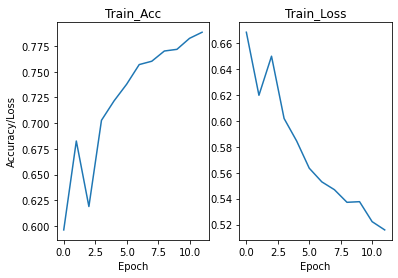

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Train_Acc")
plt.plot(history['train_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.subplot(1, 2, 2)
plt.title("Train_Loss")
plt.plot(history['train_loss'])
plt.xlabel("Epoch")
# plt.ylabel("Accuracy/Loss")
plt.show()

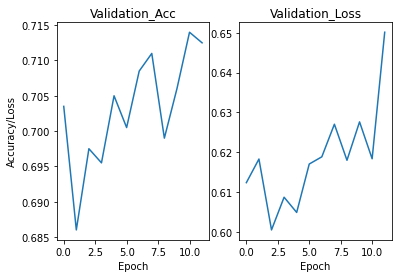

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Validation_Acc")
plt.plot(history['val_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.subplot(1, 2, 2)
plt.title("Validation_Loss")
plt.plot(history['val_loss'])
plt.xlabel("Epoch")
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
print(len(history['train_acc']))

20


In [ ]:
MAX_LEN = 256
BATCH_SIZE = 2
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df.Label.values)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test.Label.values)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
  )

loss_fn = nn.CrossEntropyLoss().to(device)


for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 30)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, int(len(df_train)))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    int(len(df_val))
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
        
test_acc, _ = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      int(len(df_test))
      )
print('\nTest Accuracy:\n')
print(test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
  )

print(classification_report(y_test, y_pred, target_names=class_names))

Epoch 1/10
------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.7279690839385203 accuracy 0.5007045561296384
Val   loss 0.6920778090344336 accuracy 0.5

Epoch 2/10
------------------------------
Train loss 0.722093672987441 accuracy 0.5129168623767028
Val   loss 0.6955177317884632 accuracy 0.5

Epoch 3/10
------------------------------
Train loss 0.7286150044398688 accuracy 0.4983560356975106
Val   loss 0.6945984574188864 accuracy 0.5

Epoch 4/10
------------------------------
Train loss 0.712162407714996 accuracy 0.5241897604509159
Val   loss 0.6957106276562339 accuracy 0.5

Epoch 5/10
------------------------------
Train loss 0.7214727595658369 accuracy 0.49412869891968064
Val   loss 0.6937851063290933 accuracy 0.5

Epoch 6/10
------------------------------
Train loss 0.7203960887982812 accuracy 0.502113668388915
Val   loss 0.6932360144486105 accuracy 0.5

Epoch 7/10
------------------------------
Train loss 0.7281022059525682 accuracy 0.4856740253640207
Val   loss 0.6933058034208485 accuracy 0.5

Epoch 8/10
-------------------------